## Boston Marathon Data:

### 1. Importing:

In [168]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
from IPython.display import Markdown
%matplotlib inline

In [169]:
df = pd.read_csv('2014BostonMarathon.csv')

### 2. Exploratory Analysis and Cleaning:

#### A. Null Values and Dropping Some:

In [194]:
# Looking at null-values:

starting_row_ct = len(df)
starting_nulls = pd.DataFrame(df.isna().sum())
starting_nulls = starting_nulls.where(starting_nulls.values != 0).dropna()

   Here is our starting row count: {{starting_row_ct}}.  
    
   We will wait before doing anything with a significant number of null-values, but it is good to know where
    our null-values are before setting out on further exploration. In this table we have removed all of the
    columns which do not have null-values, and isolated the columns that do have null-values: {{starting_nulls}}
        
   In the cell below, we will drop our 'Citizenship' feature (since it is similar to/overly-correlated with 
    our 'Country' feature). We will also drop the singular null-value in 'City', as it will be inconsequential
    and will lesson our errors as we move forward.

In [195]:
# Dropping 'Citizenship':

df.drop('ctz', axis = 1, inplace = True)

# Dropping the null-value in 'City':

df.dropna(axis = 0, how = 'any', subset = ['city'], inplace = True)

#### B. Understanding the Structure and Distrubution:

In [228]:
object_descr = df.describe(include = 'O')
num_descr = df.describe()
objects = pd.DataFrame(df.dtypes.loc[df.dtypes == 'O'])
ints = pd.DataFrame(df.dtypes.loc[df.dtypes == 'int64'])
floats = pd.DataFrame(df.dtypes.loc[df.dtypes == 'float'])

> Here, we have our feature-set and its corresponding data-types.  We can see that a lot
of our columns which we would expect to be numerical are, in fact, object-types. This shouldn't be too troublesome, but is always helpful to know as we move forward.

<table width = '600' align = 'left'>
    <tr>
    </tr>
    <tr>
        <td> {{objects}} </td>
        <td> {{ints}}    </td>
        <td> {{floats}} </td>
    </tr>
</table>

>Here we have our descriptive statistics:
 Based on these, we can see that a majority of the participants are male, and the most
 predominant state represented was Massachusets (makes sense). 


<table width = '1000' align = 'left'>
    <tr> 
    </tr>
    <tr>
        <table align = 'left' >
            <tr>  
                <td style = 'text-align:center'> Numeric Columns </td>
            </tr>
            <tr>
                <td> {{num_descr}} </td>
            </tr>
        </table>
    </tr>
</table>


<table width = '1200' align = 'left'>
    <tr> 
        <table align = 'left'>
            <tr>
               <td style = 'text-align:center'> Object Columns </td> 
            </tr>
            <tr>
               <td> {{object_descr}} </td>
            </tr>
        </table>
    </tr>    
</table>



#### C. Dash Control:

In [229]:
# Had to take care of some dashes within the dataset ('-'), which were making it difficult to run models.  
# Did not want to drop these since that would cause a lot of information loss

import re

df['5k'] = df['5k'].replace(to_replace = '-', value = np.nan)
df['10k'] = df['10k'].replace(to_replace = '-', value = np.nan)
df['20k'] = df['20k'].replace(to_replace = '-', value = np.nan)
df['25k'] = df['25k'].replace(to_replace = '-', value = np.nan)
df['30k'] = df['30k'].replace(to_replace = '-', value = np.nan)
df['35k'] = df['35k'].replace(to_replace = '-', value = np.nan)
df['40k'] = df['40k'].replace(to_replace = '-', value = np.nan)
df['half'] = df['half'].replace(to_replace = '-', value = np.nan)

#### D. Dummy Control:

In [230]:
# Had to do some grouping to control dummies:
EUR = ['TUR', 'HUN', 'LUX', 'UKR', 'BLR', 'CRO', 'EST', 'SVK', 'SLO', 'POR', 'GRE', 'CZE', 'ROU', 'LIE',
       'POL', 'AUT', 'NOR', 'BEL', 'FIN', 'ISL']
df['country'] = df['country'].where(df['country'].apply(lambda x: x not in EUR), other = 'EUR')

SEA = ['PHI', 'THA', 'MAS', 'INA', 'NZL']
df['country'] = df['country'].where(df['country'].apply(lambda x: x not in SEA), other = 'SEA')

AFR = ['EGY', 'ZIM', 'TAN', 'ETH', 'MAR', 'KEN', 'RSA']
df['country'] = df['country'].where(df['country'].apply(lambda x: x not in AFR), other = 'AFR')

CAM = ['PAN', 'DOM', 'BAH', 'CAY', 'VGB', 'BAR', 'ESA', 'GUA', 'CRC', 'BER']
df['country'] = df['country'].where(df['country'].apply(lambda x: x not in CAM), other = 'CAM')

SAM = ['ECU', 'BOL', 'TRI', 'PER', 'URU', 'ARG', 'CHI', 'VEN']
df['country'] = df['country'].where(df['country'].apply(lambda x: x not in SAM), other = 'SAM')

MEA = ['QAT', 'BRN', 'ISR', 'UAE']
df['country'] = df['country'].where(df['country'].apply(lambda x: x not in MEA), other = 'MEA')

ASI = ['IND', 'RUS', 'TPE', 'SIN']
df['country'] = df['country'].where(df['country'].apply(lambda x: x not in ASI), other = 'ASI')

#### E. Error NaN/Inf Error Mitigation:

In [231]:
# Was getting an NaN, Inf, Value Too Large error when running the preliminary models. So: 

df['pace'] = pd.to_numeric(df['pace'], downcast = 'float')
df['official'] = pd.to_numeric(df['official'], downcast = 'float')

#### F. Preliminary Visualizations:

##### F-1. Correlation:

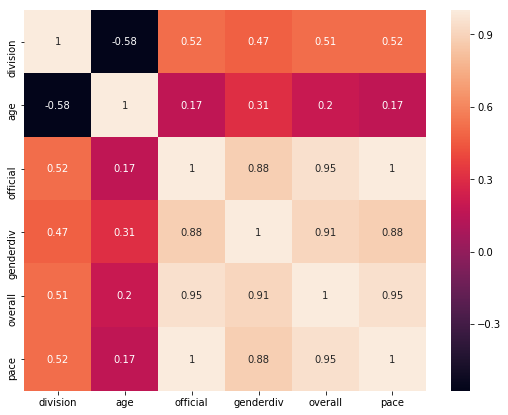

In [232]:
plt.figure(figsize = (9, 7))
sns.heatmap(df.corr(), annot = True)
plt.show()

##### F-2. Univariate Distributions:

### Using GridSearchCV to run some preliminary models:

In [37]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest

df.dropna(axis = 1, how = 'any')
end_df_len = len(df)

X = pd.get_dummies(data = df.drop(['name', 'bib', 'city', 'state', 'genderdiv'], axis = 1), columns = ['gender', 'country'])
y = df['genderdiv']

In [38]:
# Resetting the index from a value error that I was getting:

X.reset_index()
y.reset_index()



,index,genderdiv
0,0,8
1,1,1
2,2,1
3,3,3
4,4,2
5,5,4
6,6,4
7,7,5
8,8,3
9,9,20
